In [34]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import random as rnd

L1_SIZE = 56
L2_SIZE = 28
IMAGE_EDGE_SIZE = 28
PIXELS_PER_IMAGE = IMAGE_EDGE_SIZE ** 2
CLASSES_COUNT = 10
ITERATIONS = 500
LEARNING_RATE = 0.15

### Helper functions

In [47]:
def one_hot(labels):
    one_hot = np.zeros((labels.size, 10))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot.T

def get_accuracy(results, labels):
    return (np.sum(np.argmax(results, 0) == labels) / labels.size)

def show_some_mistakes(results, labels, data, samples = 10):
    results = np.argmax(results, 0)
    i = rnd.randint(0, labels.size)
    j = 0
    while j < samples:
        i = (i + 1) % labels.size
        if results[i] != labels[i]:
            print("labeled:", labels[i], "-- classified:", results[i])
            plt.imshow(data[:, i].reshape((IMAGE_EDGE_SIZE, IMAGE_EDGE_SIZE)), cmap='gray')
            plt.show()
            j += 1

def assess_2L():
    W1 = np.load("W1_2L.npy")
    W2 = np.load("W2_2L.npy")
    B1 = np.load("B1_2L.npy")
    B2 = np.load("B2_2L.npy")
    print("\n###################### 2 layers results ######################\n")

    training_data, training_labels = load_training_data()
    Z1, Z2, A1, A2 = forward_prop_2L(W1, W2, B1, B2, training_data)
    print("Accuracy on training set: ", get_accuracy(A2, training_labels))

    test_data, test_labels = load_test_data()
    Z1, Z2, A1, A2 = forward_prop_2L(W1, W2, B1, B2, test_data)
    print("Accuracy on test set: ", get_accuracy(A2, test_labels))

    show_some_mistakes(A2, test_labels, test_data)

def assess_3L():
    W1 = np.load("W1_3L.npy")
    W2 = np.load("W2_3L.npy")
    W3 = np.load("W3_3L.npy")
    B1 = np.load("B1_3L.npy")
    B2 = np.load("B2_3L.npy")
    B3 = np.load("B3_3L.npy")
    print("\n###################### 3 layers results ######################\n")

    training_data, training_labels = load_training_data()
    Z1, Z2, Z3, A1, A2, A3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, training_data)
    print("Accuracy on training set: ", get_accuracy(A3, training_labels))

    test_data, test_labels = load_test_data()
    Z1, Z2, Z3, A1, A2, A3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, test_data)
    print("Accuracy on test set: ", get_accuracy(A3, test_labels))

    show_some_mistakes(A3, test_labels, test_data)

### Non linear functions

In [36]:
def ReLU(Z):
    return np.maximum(0, Z)

def softmax(Z):
    return np.exp(Z) / sum(np.exp(Z))

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

### Forward and backward propagation

In [37]:
def forward_prop_2L(W1, W2, B1, B2, training_data):
    Z1 = W1.dot(training_data) + B1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + B2
    A2 = softmax(Z2)
    return Z1, Z2, A1, A2

def forward_prop_3L(W1, W2, W3, B1, B2, B3, training_data):
    Z1 = W1.dot(training_data) + B1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + B2
    A2 = ReLU(Z2)
    Z3 = W3.dot(A2) + B3
    A3 = softmax(Z3)
    return Z1, Z2, Z3, A1, A2, A3

def back_prop_2L(Z1, A1, A2, W2, training_data, labels, sample_count):
    dZ2 = A2 - labels
    dW2 = dZ2.dot(A1.T) / sample_count
    dB2 = np.sum(dZ2) / sample_count
    dZ1 = W2.T.dot(dZ2) * (Z1 > 0)
    dW1 = dZ1.dot(training_data.T) / sample_count
    dB1 = np.sum(dZ1) / sample_count
    return dW1, dW2, dB1, dB2

def back_prop_3L(Z1, Z2, A1, A2, A3, W2, W3, training_data, labels, sample_count):
    dZ3 = A3 - labels
    dW3 = dZ3.dot(A2.T) / sample_count
    dB3 = np.sum(dZ3) / sample_count
    dZ2 = W3.T.dot(dZ3) * (Z2 > 0)
    dW2 = dZ2.dot(A1.T) / sample_count
    dB2 = np.sum(dZ2) / sample_count
    dZ1 = W2.T.dot(dZ2) * (Z1 > 0)
    dW1 = dZ1.dot(training_data.T) / sample_count
    dB1 = np.sum(dZ1) / sample_count
    return dW1, dW2, dW3, dB1, dB2, dB3

### Adjusting weights and biases after a training cycle

In [38]:
def weights_adjust_2L(W1, W2, dW1, dW2, learning_rate):
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    return W1, W2

def weights_adjust_3L(W1, W2, W3, dW1, dW2, dW3, learning_rate):
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    W3 = W3 - learning_rate * dW3
    return W1, W2, W3

def biases_adjust_2L(B1, B2, dB1, dB2, learning_rate):
    B1 = B1 - learning_rate * dB1
    B2 = B2 - learning_rate * dB2
    return B1, B2

def biases_adjust_3L(B1, B2, B3, dB1, dB2, dB3, learning_rate):
    B1 = B1 - learning_rate * dB1
    B2 = B2 - learning_rate * dB2
    B3 = B3 - learning_rate * dB3
    return B1, B2, B3

### Initialization of weights and biases

In [39]:
def weights_init_2L(width, start_width = PIXELS_PER_IMAGE, end_width = CLASSES_COUNT):
    W1 = np.random.rand(width, start_width) - 0.5
    W2 = np.random.rand(end_width, width) - 0.5
    return W1, W2

def weights_init_3L(l1_width, l2_width, start_width = PIXELS_PER_IMAGE, end_width = CLASSES_COUNT):
    W1 = np.random.rand(l1_width, start_width) - 0.5
    W2 = np.random.rand(l2_width, l1_width) - 0.5
    W3 = np.random.rand(end_width, l2_width) - 0.5
    return W1, W2, W3

def biases_init_2L(width, end_width = 10):
    B1 = np.random.rand(width, 1) - 0.5
    B2 = np.random.rand(end_width, 1) - 0.5
    return B1, B2

def biases_init_3L(l1_width, l2_width, end_width = CLASSES_COUNT):
    B1 = np.random.rand(l1_width, 1) - 0.5
    B2 = np.random.rand(l2_width, 1) - 0.5
    B3 = np.random.rand(end_width, 1) - 0.5
    return B1, B2, B3

### Gradient descend

In [40]:
def gradient_descend_2L(training_data, labels, iterations, learning_rate):
    W1, W2 = weights_init_2L(L1_SIZE)
    B1, B2 = biases_init_2L(L1_SIZE)
    one_hot_labels = one_hot(labels)

    for _ in range(iterations):
        Z1, Z2, A1, A2 = forward_prop_2L(W1, W2, B1, B2, training_data)
        dW1, dW2, dB1, dB2 = back_prop_2L(Z1, A1, A2, W2, training_data, one_hot_labels, labels.size)
        W1, W2 = weights_adjust_2L(W1, W2, dW1, dW2, learning_rate)
        B1, B2 = biases_adjust_2L(B1, B2, dB1, dB2, learning_rate)

    return W1, W2, B1, B2

def gradient_descend_3L(training_data, labels, iterations, learning_rate):
    W1, W2, W3 = weights_init_3L(L1_SIZE, L2_SIZE)
    B1, B2, B3 = biases_init_3L(L1_SIZE, L2_SIZE)
    one_hot_labels = one_hot(labels)

    for _ in range(iterations):
        Z1, Z2, Z3, A1, A2, A3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, training_data)
        dW1, dW2, dW3, dB1, dB2, dB3 = back_prop_3L(Z1, Z2, A1, A2, A3, W2, W3, training_data, one_hot_labels, labels.size)
        W1, W2, W3 = weights_adjust_3L(W1, W2, W3, dW1, dW2, dW3, learning_rate)
        B1, B2, B3 = biases_adjust_3L(B1, B2, B3, dB1, dB2, dB3, learning_rate)

    return W1, W2, W3, B1, B2, B3

### Training functions

In [41]:
def train_3L(training_data, training_labels, iterations, learning_rate):
    W1, W2, W3, B1, B2, B3 = gradient_descend_3L(training_data, training_labels, iterations, learning_rate)

    np.save("W1_3L.npy", W1)
    np.save("W2_3L.npy", W2)
    np.save("W3_3L.npy", W3)
    np.save("B1_3L.npy", B1)
    np.save("B2_3L.npy", B2)
    np.save("B3_3L.npy", B3)

def train_2L(training_data, training_labels, iterations, learning_rate):
    W1, W2, B1, B2 = gradient_descend_2L(training_data, training_labels, iterations, learning_rate)

    np.save("W1_2L.npy", W1)
    np.save("W2_2L.npy", W2)
    np.save("B1_2L.npy", B1)
    np.save("B2_2L.npy", B2)

### Loading of training and testing data

In [42]:
def load_training_data():
    training_data = idx2numpy.convert_from_file("mnist/train-images.idx3-ubyte")
    training_labels = idx2numpy.convert_from_file("mnist/train-labels.idx1-ubyte")
    sample_count = training_data.shape[0]
    training_data = np.reshape(training_data, (sample_count, -1)).T / 255
    return training_data, training_labels

def load_test_data():
    test_data = idx2numpy.convert_from_file("mnist/t10k-images.idx3-ubyte")
    test_labels = idx2numpy.convert_from_file("mnist/t10k-labels.idx1-ubyte")
    sample_count = test_data.shape[0]
    test_data = np.reshape(test_data, (sample_count, -1)).T / 255
    return test_data, test_labels

### Training

In [43]:
training_data, training_labels = load_training_data()
train_3L(training_data, training_labels, ITERATIONS, LEARNING_RATE)
train_2L(training_data, training_labels, ITERATIONS, LEARNING_RATE)

### Result assessment


###################### 2 layers results ######################

Accuracy on training set:  0.9008666666666667
Accuracy on test set:  0.9026
labeled: 4 -- classified: 7


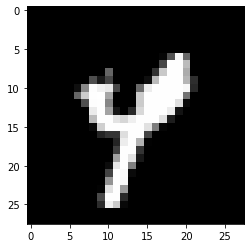

labeled: 9 -- classified: 7


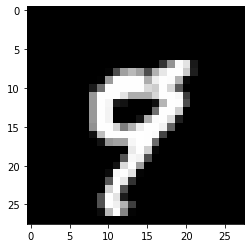

labeled: 9 -- classified: 7


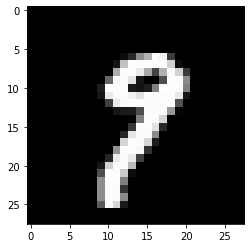

labeled: 8 -- classified: 2


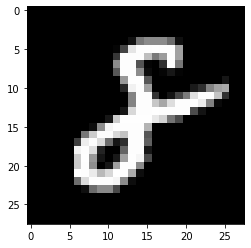

labeled: 9 -- classified: 4


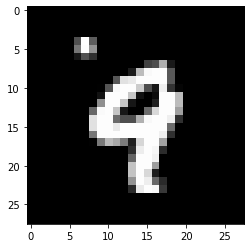

labeled: 2 -- classified: 6


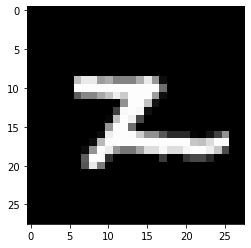

labeled: 6 -- classified: 5


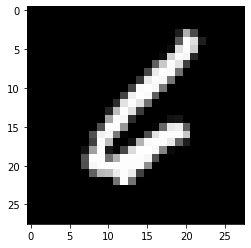

labeled: 1 -- classified: 2


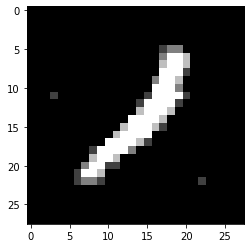

labeled: 3 -- classified: 5


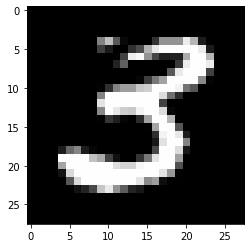

labeled: 3 -- classified: 5


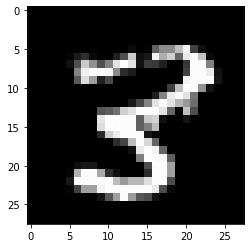


###################### 3 layers results ######################

Accuracy on training set:  0.9107333333333333
Accuracy on test set:  0.9117
labeled: 4 -- classified: 9


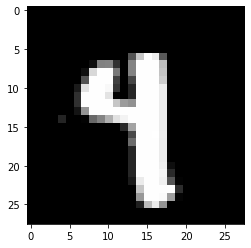

labeled: 8 -- classified: 6


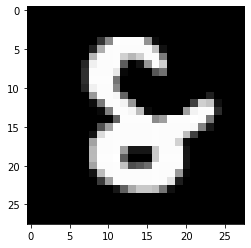

labeled: 6 -- classified: 4


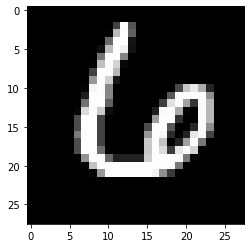

labeled: 2 -- classified: 3


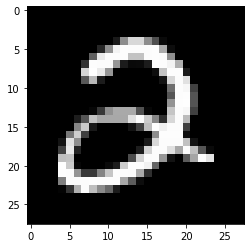

labeled: 3 -- classified: 8


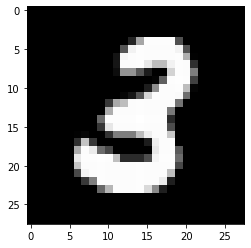

labeled: 5 -- classified: 6


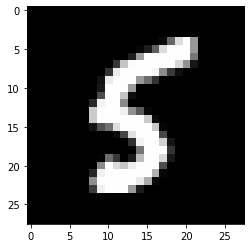

labeled: 5 -- classified: 6


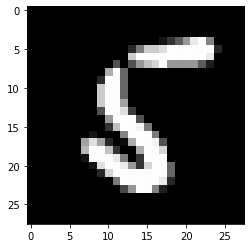

labeled: 7 -- classified: 2


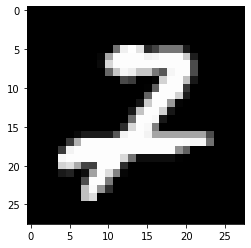

labeled: 2 -- classified: 8


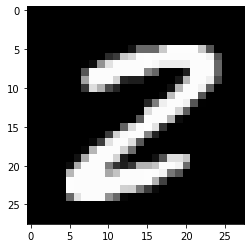

labeled: 7 -- classified: 2


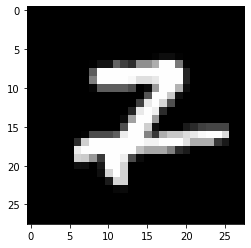

In [48]:
assess_2L()
assess_3L()